# Data Manipulation using Apache Spark
In this notebook, we will be using Apache Spark environment for data generation, manipulation, and exploration.


##### Disclaimer: this notebook is created for academic purposes

##### Summary

    1. Spark environment preparation
    2. Existing data extraction, exploration, and data loading into Spark from CSV
    3. Relational database schema and DDL design
    4. Database deployment into a suitable relational database
    5. New sample (fake) data generation based on the designed schema 
    6. Sample data loading to the database using Apache Spark
    7. DataFrames serialisation into Apache Parquet format
    8. Data loading to DataFrames for further use 

In [13]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/project/spark-3.2.1-bin-hadoop3.2"

In [14]:
# Apache Spark environment preparation
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id,row_number
import pyspark.sql.functions as f
from PIL import Image

sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession \
    .builder \
    .appName("PySpark App") \
    .config("spark.jars", "/path/postgresql-42.3.3.jar") \
    .getOrCreate()

import numpy as np

In [15]:
# Setup path to connect with database
postgres_uri = "jdbc:postgresql://depgdb.crhso94tou3n.eu-west-2.rds.amazonaws.com:5432/marianapitupulu21"
dbtable_merchant = "electronic_price_schema.merchant"
dbtable_pricing = "electronic_price_schema.pricing"
dbtable_manufacturer = "electronic_price_schema.manufacturer"
dbtable_product = "electronic_price_schema.product"

# Define user name & password to access the database
user = <<username>>
password = <<password>>

In [1]:
# Read merchant table
df_merchant = spark.read \
    .format("jdbc") \
    .option("url", postgres_uri) \
    .option("dbtable", dbtable_merchant) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_merchant.printSchema()

In [6]:
# Read pricing table
df_pricing = spark.read \
    .format("jdbc") \
    .option("url", postgres_uri) \
    .option("dbtable", dbtable_pricing) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_pricing.printSchema()

root
 |-- pricing_id: integer (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- date_seen: timestamp (nullable = true)
 |-- price_max: double (nullable = true)
 |-- price_min: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- issale: boolean (nullable = true)
 |-- price_source_url: string (nullable = true)



In [7]:
# Read manufacturer table
df_manufacturer = spark.read \
    .format("jdbc") \
    .option("url", postgres_uri) \
    .option("dbtable", dbtable_manufacturer) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_manufacturer.printSchema()

root
 |-- manufacturer_id: integer (nullable = true)
 |-- manufacturer_name: string (nullable = true)



In [8]:
# Read product table
df_product = spark.read \
    .format("jdbc") \
    .option("url", postgres_uri) \
    .option("dbtable", dbtable_product) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_product.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- pricing_id: integer (nullable = true)
 |-- upc_id: integer (nullable = true)
 |-- manufacturer_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- asins: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- primary_categories: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- availability: integer (nullable = true)
 |-- condition: string (nullable = true)
 |-- weight: double (nullable = true)
 |-- product_url: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- date_added: timestamp (nullable = true)



## Extract and Explore the Dataset

In [711]:
# Load dataset from csv
df = sqlContext.read.csv("/path/DatafinitiElectronicsProductsPricingData.csv",header=True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- prices.amountMax: string (nullable = true)
 |-- prices.amountMin: string (nullable = true)
 |-- prices.availability: string (nullable = true)
 |-- prices.condition: string (nullable = true)
 |-- prices.currency: string (nullable = true)
 |-- prices.dateSeen: string (nullable = true)
 |-- prices.isSale: string (nullable = true)
 |-- prices.merchant: string (nullable = true)
 |-- prices.shipping: string (nullable = true)
 |-- prices.sourceURLs: string (nullable = true)
 |-- asins: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- dateAdded: string (nullable = true)
 |-- dateUpdated: string (nullable = true)
 |-- ean: string (nullable = true)
 |-- imageURLs: string (nullable = true)
 |-- keys: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- manufacturerNumber: string (nullable = true)
 |-- name: string (nullable = true)
 |-- primaryCategories: string (nullable =

In [646]:
df.count()

7249

In [647]:
# Total unique merchants recorded
df.registerTempTable("temp_df")
df.select("`prices.merchant`").distinct().count()

695

In [648]:
# Total unique brands recorded
df.registerTempTable("temp_df")
df.select("brand").distinct().count()

259

In [649]:
# 10 brands with the highest aggregate maximum prices 
a=df.groupBy('brand').agg(f.max('`prices.amountMax`'))
a.show(10)                  

+--------------+-----------------------+
|         brand|max(`prices.amountMax`)|
+--------------+-----------------------+
|        Belkin|                 349.99|
|         Denon|                 999.98|
|         Thule|                  59.99|
| Grace Digital|                 169.99|
|  Outdoor Tech|                  71.99|
|         Razer|                4399.99|
|        IOGEAR|                  79.99|
|         Onkyo|                 699.99|
|Master Dynamic|                 399.98|
|          Sima|                 209.99|
+--------------+-----------------------+
only showing top 10 rows



In [765]:
# Show all data from Belkin 
df.registerTempTable("temp")

temp= sqlContext.sql("SELECT * FROM temp where brand == 'Belkin'")
temp.show(5)

+--------------------+----------------+----------------+-------------------+----------------+---------------+--------------------+-------------+----------------+--------------------+--------------------+----------+------+--------------------+--------------------+--------------------+----+--------------------+--------------------+------------+------------------+--------------------+-----------------+--------------------+--------+--------------------+----+----+----+----+----+
|                  id|prices.amountMax|prices.amountMin|prices.availability|prices.condition|prices.currency|     prices.dateSeen|prices.isSale| prices.merchant|     prices.shipping|   prices.sourceURLs|     asins| brand|          categories|           dateAdded|         dateUpdated| ean|           imageURLs|                keys|manufacturer|manufacturerNumber|                name|primaryCategories|          sourceURLs|     upc|              weight|_c26|_c27|_c28|_c29|_c30|
+--------------------+----------------+---

## Relational Database

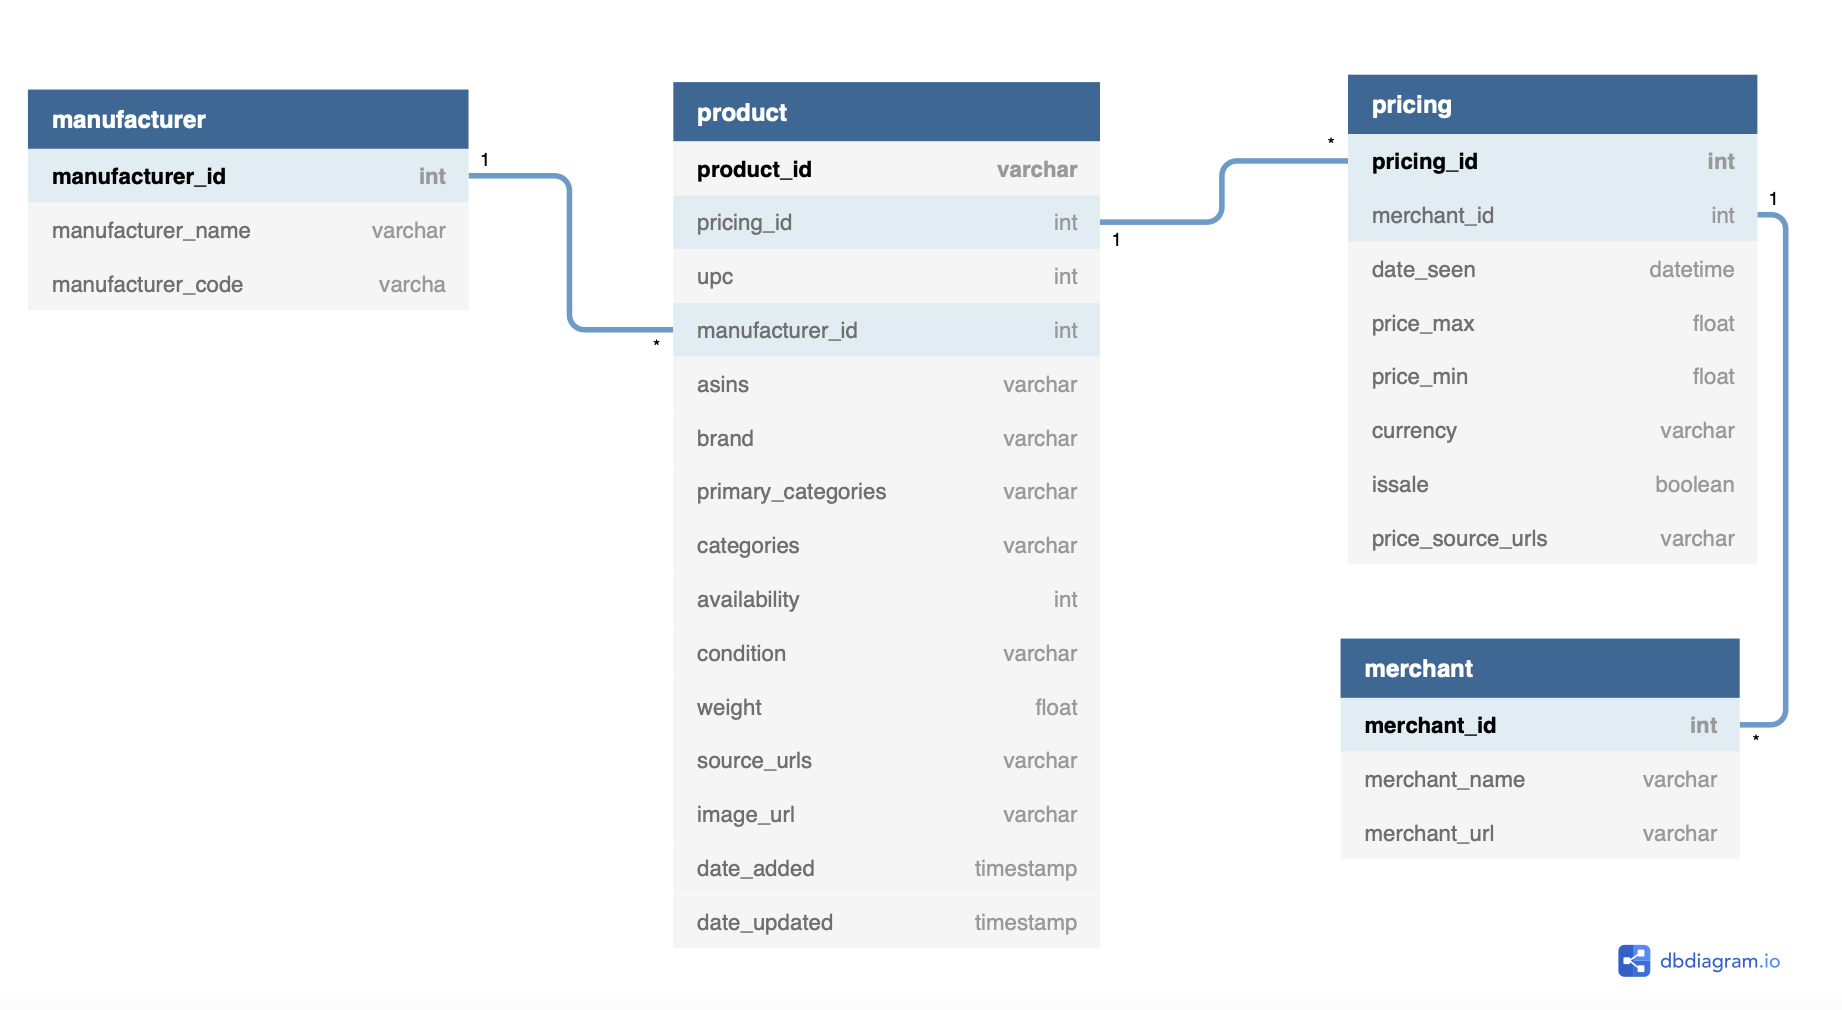

In [609]:
image = Image.open('/path/relational_db.png')
image.show()

## Transform a Small Subset from the Dataset

In [447]:
df_subset = spark.createDataFrame(df.head(10),schema=df.schema)

In [666]:
# Generate dataframe based on the created schema
# Create merchant table
df_merchant=df_subset.selectExpr('`prices.merchant` as merchant_name').distinct()
df_merchant=df_merchant=
df_merchant=df_merchant.withColumn("merchant_id",row_number().over(Window.orderBy(monotonically_increasing_id())))

In [667]:
df_merchant.show()

+--------------------+-----------+
|       merchant_name|merchant_id|
+--------------------+-----------+
|         Walmart.com|          1|
|         Bestbuy.com|          2|
|California Electr...|          3|
+--------------------+-----------+



In [668]:
# Create manufacturer table
df_manufacturer=df_subset.selectExpr('manufacturer as manufacturer_name','manufacturerNumber as manufacturer_code').distinct()
df_manufacturer=df_manufacturer.withColumn("manufacturer_id",row_number().over(Window.orderBy(monotonically_increasing_id())))

In [669]:
df_manufacturer.show()

+-----------------+-----------------+---------------+
|manufacturer_name|manufacturer_code|manufacturer_id|
+-----------------+-----------------+---------------+
|          Boytone|          BT-210F|              1|
|             null|         VLF410B1|              2|
+-----------------+-----------------+---------------+



In [728]:
# Create pricing table
df_pricing = df_subset.selectExpr('`prices.amountMax` as price_max','`prices.amountMin` as price_min',
                                '`prices.currency` as currency','`prices.dateSeen` as date_seen','`prices.isSale` as issale',
                                '`prices.sourceURLs` as price_source_urls','`prices.merchant` as merchant_name').distinct()

df_pricing = df_pricing.withColumn("pricing_id", row_number().over(Window.orderBy(monotonically_increasing_id())))

# Assign the foreign key merchant_id
df_pricing = df_pricing.withColumn("merchant_id", \
   when((df_pricing.merchant_name == "Bestbuy.com"), lit(1)) \
     .when((df_pricing.merchant_name == "Walmart.com"), lit(2)) \
     .when((df_pricing.merchant_name == "California Electronics"), lit(3)))

# Drop unused column
df_pricing = df_pricing.drop(df_pricing.merchant_name)

df_pricing.show()

+---------+---------+--------+--------------------+------+--------------------+----------+-----------+
|price_max|price_min|currency|           date_seen|issale|   price_source_urls|pricing_id|merchant_id|
+---------+---------+--------+--------------------+------+--------------------+----------+-----------+
|   104.99|   104.99|     USD|2017-03-30T06:00:...| FALSE|http://www.bestbu...|         1|          1|
|       69|    64.99|     USD|2017-12-14T06:00:00Z|  TRUE|https://www.walma...|         2|          2|
|    69.99|    69.99|     USD|2017-10-10T05:00:00Z| FALSE|https://www.bestb...|         3|          1|
|       69|       69|     USD|2017-09-08T05:00:00Z| FALSE|https://www.walma...|         4|          2|
|       66|       66|     USD|2017-10-24T04:00:00Z| FALSE|https://www.walma...|         5|          2|
|    66.99|    66.99|     USD|2017-08-28T07:00:00Z| FALSE|https://www.bestb...|         6|          1|
|    65.99|    65.99|     USD|2017-08-12T09:00:00Z| FALSE|http://www.best

In [716]:
# Create product table
df_product = df_subset.selectExpr('upc','asins','brand','primaryCategories as primary_categories',
                                  'categories','`prices.availability` as availability','`prices.condition` as condition',
                                  'weight','sourceURLs as source_urls','imageURLs as image_urls', 
                                  'dateAdded as date_added','dateUpdated as date_updated').distinct()


df_product = df_product.withColumn("product_id", row_number().over(Window.orderBy(monotonically_increasing_id())))

# Define function to randomize number for foreign key pricing_id
def f(x):
    return np.random.randint(10)

# Assign random number for foreign key id
fk_pricing = sc.parallelize([1] * 10).map(f)
fk_pricing=fk_pricing.collect()
fk_pricing = sqlContext.createDataFrame([(l+1,) for l in fk_pricing], ['pricing_id'])

# Join both dataframe to get the final product table
temp_fk = fk_pricing.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
temp_data = df_product.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

df_product = temp_fk.join(temp_data, temp_fk.row_idx == temp_data.row_idx).\
             drop("row_idx")

# Define function to randomize number for foreign key manufacturer_id
def f(x):
    return np.random.randint(3)

# Assign random number for foreign key id
fk_manufacturer = sc.parallelize([1] * 3).map(f)
fk_manufacturer=fk_manufacturer.collect()
fk_manufacturer = sqlContext.createDataFrame([(l+1,) for l in fk_manufacturer], ['manufacturer_id'])

# Join both dataframe to get the final product table
temp_fk= fk_manufacturer.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
temp_data = df_product.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
df_product = temp_fk.join(temp_data, temp_fk.row_idx == temp_data.row_idx).\
             drop("row_idx")

df_product.show()

+---------------+----------+--------+--------------------+-------+------------------+--------------------+------------+---------+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|manufacturer_id|pricing_id|     upc|               asins|  brand|primary_categories|          categories|availability|condition|     weight|         source_urls|          image_urls|          date_added|        date_updated|product_id|
+---------------+----------+--------+--------------------+-------+------------------+--------------------+------------+---------+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|              3|        10|7.94E+11|          B00C78VIUE|  Sanus|       Electronics|Audio & Video Acc...|         Yes|      New|32.8 pounds|https://www.amazo...|https://images-na...|2015-04-13T12:00:51Z|2018-05-12T18:59:48Z|         1|
|              3|         7|6.42E+11|B018K251JE,B00V

## Load Sample Data into the Database using Apache Spark

In [572]:
spark = SparkSession \
    .builder \
    .appName("PySpark App") \
    .config("spark.jars", "/path/postgresql-42.3.2.jar") \
    .getOrCreate()

In [574]:
# Setup path to connect with database
postgres_uri = "jdbc:postgresql://depgdb.crhso94tou3n.eu-west-2.rds.amazonaws.com:5432/<<username>>"
dbtable_merchant= "electronic_price_schema.merchant"
dbtable_manufacturer = "electronic_price_schema.manufacturer"
dbtable_pricing = "electronic_price_schema.pricing"
dbtable_product = "electronic_price_schema.product"

# Define username and password to access the database
user = "<<username>>"
password = "<<password>>"

In [724]:
# Write sample data into the Database using Apache Spark
df_merchant.select("merchant_name","merchant_id").write.format("jdbc") \
    .option("url", postgres_uri) \
    .option("driver", "org.postgresql.Driver") \
    .option("dbtable","electronic_price_schema.merchant") \
    .option("user", user) \
    .mode("append") \
    .option("password", password).save()

In [725]:
df_manufacturer.select("manufacturer_id","manufacturer_name","manufacturer_code").write.format("jdbc") \
    .option("url", postgres_uri) \
    .option("driver", "org.postgresql.Driver") \
    .option("dbtable","electronic_price_schema.manufacturer") \
    .option("user", user) \
    .mode("append") \
    .option("password", password).save()

In [729]:
df_pricing.select("pricing_id","merchant_id","date_seen","price_max","price_min",
                  "currency","issale","price_source_urls").write.format("jdbc") \
    .option("url", postgres_uri) \
    .option("driver", "org.postgresql.Driver") \
    .option("dbtable","electronic_price_schema.pricing") \
    .option("user", user) \
    .mode("append") \
    .option("password", password).save()

In [719]:
# Write sample data into the Database using Apache Spark
df_product.select('upc','asins','brand','primary_categories','categories','availability','condition',
                  'weight','source_urls','image_urls','date_added','date_updated','product_id','manufacturer_id').write.format("jdbc") \
    .option("url", postgres_uri) \
    .option("driver", "org.postgresql.Driver") \
    .option("dbtable","electronic_price_schema.product") \
    .option("user", user) \
    .mode("append") \
    .option("password", password).save()

In [726]:
# Read database
merchant = spark.read \
    .format("jdbc") \
    .option("url", postgres_uri) \
    .option("dbtable", dbtable_merchant) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

merchant.show()

+-----------+--------------------+
|merchant_id|       merchant_name|
+-----------+--------------------+
|          1|         Walmart.com|
|          2|         Bestbuy.com|
|          3|California Electr...|
+-----------+--------------------+



In [727]:
# Read database
manufacturer = spark.read \
    .format("jdbc") \
    .option("url", postgres_uri) \
    .option("dbtable", dbtable_manufacturer) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

manufacturer.show()

+---------------+-----------------+-----------------+
|manufacturer_id|manufacturer_name|manufacturer_code|
+---------------+-----------------+-----------------+
|              1|          Boytone|          BT-210F|
|              2|             null|         VLF410B1|
+---------------+-----------------+-----------------+



In [730]:
# Read database
pricing = spark.read \
    .format("jdbc") \
    .option("url", postgres_uri) \
    .option("dbtable", dbtable_pricing) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

pricing.show()

+----------+-----------+--------------------+---------+---------+--------+------+--------------------+
|pricing_id|merchant_id|           date_seen|price_max|price_min|currency|issale|   price_source_urls|
+----------+-----------+--------------------+---------+---------+--------+------+--------------------+
|         1|          1|2017-03-30T06:00:...|   104.99|   104.99|     USD| FALSE|http://www.bestbu...|
|         2|          2|2017-12-14T06:00:00Z|       69|    64.99|     USD|  TRUE|https://www.walma...|
|         3|          1|2017-10-10T05:00:00Z|    69.99|    69.99|     USD| FALSE|https://www.bestb...|
|         4|          2|2017-09-08T05:00:00Z|       69|       69|     USD| FALSE|https://www.walma...|
|         5|          2|2017-10-24T04:00:00Z|       66|       66|     USD| FALSE|https://www.walma...|
|         6|          1|2017-08-28T07:00:00Z|    66.99|    66.99|     USD| FALSE|https://www.bestb...|
|         7|          1|2017-08-12T09:00:00Z|    65.99|    65.99|     USD

In [723]:
# Read database
product = spark.read \
    .format("jdbc") \
    .option("url", postgres_uri) \
    .option("dbtable", dbtable_product) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

product.show()

+----------+----------+--------+---------------+--------------------+-------+------------------+--------------------+------------+---------+-----------+--------------------+--------------------+--------------------+--------------------+
|product_id|pricing_id|     upc|manufacturer_id|               asins|  brand|primary_categories|          categories|availability|condition|     weight|         source_urls|          image_urls|          date_added|        date_updated|
+----------+----------+--------+---------------+--------------------+-------+------------------+--------------------+------------+---------+-----------+--------------------+--------------------+--------------------+--------------------+
|         1|      null|7.94E+11|              3|          B00C78VIUE|  Sanus|       Electronics|Audio & Video Acc...|         Yes|      New|32.8 pounds|https://www.amazo...|https://images-na...|2015-04-13T12:00:51Z|2018-05-12T18:59:48Z|
|         2|      null|6.42E+11|              3|B018

## Serialise the DataFrames into Apache Parquet Format

In [703]:
# Write the tables into parquet
df_merchant.write.parquet("/project/merch.parquet")
df_manufacturer.write.parquet("/project/manuf.parquet")
df_pricing.write.parquet("/project/price.parquet")
df_product.write.parquet("/project/product.parquet")

## Load the Results of the DataFrames into a Pandas DataFrame

In [777]:
# Read parquet
parq_merchant=pd.read_parquet("/path/merch.parquet")
parq_merchant.head().T

,0,1,2
merchant_name,Walmart.com,Bestbuy.com,California Electronics
merchant_id,1,2,3


In [776]:
# Read parquet
parq_manufacturer=pd.read_parquet("/path/manuf.parquet")
parq_manufacturer.head().T

,0,1
manufacturer_name,Boytone,None
manufacturer_code,BT-210F,VLF410B1
manufacturer_id,1,2


In [775]:
# Read parquet
parq_pricing=pd.read_parquet("/path/price.parquet")
parq_pricing.head().T

,0,1,2,3,4
price_max,104.99,69,69.99,69,66
price_min,104.99,64.99,69.99,69,66
currency,USD,USD,USD,USD,USD
date_seen,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",2017-12-14T06:00:00Z,2017-10-10T05:00:00Z,2017-09-08T05:00:00Z,2017-10-24T04:00:00Z
issale,FALSE,TRUE,FALSE,FALSE,FALSE
price_source_urls,http://www.bestbuy.com/site/sanus-tv-wall-moun...,https://www.walmart.com/ip/BOYTONE-BT210FB-BLA...,https://www.bestbuy.com/site/boytone-2500w-2-1...,https://www.walmart.com/ip/Boytone-BT-210F-Blu...,https://www.walmart.com/ip/Boytone-BT-210F-Blu...
pricing_id,1,2,3,4,5
merchant_id,1,2,1,2,2


In [774]:
# Read parquet
parq_product=pd.read_parquet("/path/product.parquet")
parq_product.head().T

,0,1,2
manufacturer_id,2,2,2
pricing_id,9,10,10
upc,7.94E+11,6.42E+11,6.42E+11
asins,B00C78VIUE,"B018K251JE,B00VILQKQ8","B018K251JE,B00VILQKQ8"
brand,Sanus,Boytone,Boytone
primary_categories,Electronics,Electronics,Electronics
categories,"Audio & Video Accessories,TV Mounts,TV Accesso...","Stereos,Portable Bluetooth Speakers,TV, Video ...","Stereos,Portable Bluetooth Speakers,TV, Video ..."
availability,Yes,In Stock,Yes
condition,New,New,New
weight,32.8 pounds,14 pounds,14 pounds
